# Informatics Collaboration Network

In this notebook, we create and visualise three different models of the informatics network:
- [InfNet-20yr](#Simple-collaboration-network) : everyone in the School
- [InfNet-6yr](#6yr-model): network based on the publications from 2012-2017
- [Weighted InfNet-6yr)](#Weighted-6yr-Model) : network weighted by the number of collaboration between nodes

In [1]:
SAVE_GRAPHS = True

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pickle as pkl
import numpy as np
from numpy.random import RandomState  # random_state for networkX only for python3.6
rng = RandomState(787351)
import os
DATA_DIR = '../../data/data_schoolofinf'

## Setup `lookup_pub`

In [3]:
# Import the dataset for publication:
lookup_pub = pd.read_pickle(os.path.join(DATA_DIR, 'lookup_pub_w_yr.pkl'))

In [4]:
# def fix_date(x):
#     if len(str(x)) > 4:
#         yr = int(x[-2:])
#         if yr >= 50:
#             return 1900 + yr
#         else:
#             return 2000 + yr
#     else:
#         return int(x)

In [5]:
# lookup_pub['year'] = lookup_pub['year'].apply(lambda x: fix_date(x))

In [6]:
# lookup_pub.to_pickle(os.path.join(DATA_DIR,'lookup_pub_w_yr.pkl'))

In [7]:
len(lookup_pub)

8867

In [8]:
lookup_pub = lookup_pub.drop(
    lookup_pub[(lookup_pub.year < 1997) | (lookup_pub.year > 2017)].index)

In [9]:
len(lookup_pub)

8028

We can add the year that an individual makes his/her first publication. This would allow us to create a temporal evolution of the network graph.

## Setup `lookup_poinf` 
(lookup table for people of informatics)

In [10]:
lookup_poinf = pd.read_pickle(os.path.join(DATA_DIR, 'lookup_poinf_w_yr.pkl'))

In [11]:
# def get_firstPublishDate(poinf_id):
#     for collab in lookup_pub_sorted_yrs.iterrows():
#         poinf_collabs = collab[1]['poinf_collaborators']
#         if poinf_id in poinf_collabs:
#             return int(collab[1]['year'])

In [12]:
# lookup_poinf['first_pub_year'] = lookup_poinf.index.map(get_firstPublishDate)
# lookup_poinf.drop(
#     lookup_poinf[lookup_poinf.first_pub_year.isnull()].index, inplace=True)

In [13]:
# lookup_poinf.to_pickle(os.path.join(DATA_DIR, 'lookup_poinf_w_yr.ppkl'))

In [14]:
lookup_poinf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 223 entries, d089bb44-7d0b-4b3f-b556-27def993d1d1 to ccd9cd8c-9aee-4ede-a388-f82641ee8d29
Data columns (total 10 columns):
last_name          223 non-null object
first_name         223 non-null object
personal_url       223 non-null object
position           223 non-null object
parent             223 non-null object
institute          223 non-null object
full_name          223 non-null object
institute_class    223 non-null int64
alias              223 non-null object
first_pub_year     223 non-null float64
dtypes: float64(1), int64(1), object(8)
memory usage: 19.2+ KB


In [15]:
# Append earliest date to lookup_poinf
lookup_pub_sorted_yrs = lookup_pub.sort_values('year')
lookup_pub_sorted_yrs.drop(['authors', 'shortnames'], inplace=True, axis=1)
lookup_pub_sorted_yrs['poinf_collaborators'] = lookup_pub_sorted_yrs[
    'collab_id'].apply(lambda row: [a for a in row if a in lookup_poinf.index])

In [16]:
lookup_pub_sorted_yrs.head(3)

year  \
pub_id                                       
3f94a4f8-26c6-434d-bed9-095962ae662d  1997   
e84d0688-1eb0-47e5-bbef-a1784fba9b22  1997   
3978b46a-856e-4727-9117-51101337d880  1997   

                                                                              collab_id  \
pub_id                                                                                    
3f94a4f8-26c6-434d-bed9-095962ae662d        [629, af9c768b-b00b-47c0-a909-364602d33392]   
e84d0688-1eb0-47e5-bbef-a1784fba9b22  [66ef2544-9295-4e01-bc75-49a28d907749, 5240, 6...   
3978b46a-856e-4727-9117-51101337d880  [58, 0e635bd1-f0fb-4f16-a68a-d0457b80eed7, a78...   

                                                                                  edges  \
pub_id                                                                                    
3f94a4f8-26c6-434d-bed9-095962ae662d      [(629, af9c768b-b00b-47c0-a909-364602d33392)]   
e84d0688-1eb0-47e5-bbef-a1784fba9b22  [(66ef2544-9295-4e01-bc75-49a28d907749, 5240),...   
3978b46a-856e-4727-9117-51101337d880  [(58, 0e635bd1-f0fb-4f16-a68a-d0457b80eed7), (...   

                                                                    poinf_collaborators  
pub_id                                                                                   
3f94a4f8-26c6-434d-bed9-095962ae662d             [af9c768b-b00b-47c0-a909-364602d33392]  
e84d0688-1eb0-47e5-bbef-a1784fba9b22             [66ef2544-9295-4e01-bc75-49a28d907749]  
3978b46a-856e-4727-9117-51101337d880  [0e635bd1-f0fb-4f16-a68a-d0457b80eed7, a78a09b...

Import information about institutes in the School of Informatics

In [17]:
institutes = pkl.load(open(os.path.join(DATA_DIR, 'institutes.pkl'), 'rb'))

In [18]:
# separate the individuals by community:
infcommunity = {}
gb = lookup_poinf.groupby('institute_class')
# Number of individuals in each classes:
for k, group in gb:
    infcommunity[k] = group
    className = [name for (name, _k) in institutes.items() if _k == k][0]
    print('class {}-{}: {}'.format(k, className, len(group)))

class 0-UNKNOWN: 10
class 1-centre for intelligent systems and their applications: 19
class 2-institute of language cognition and computation: 52
class 3-laboratory for foundations of computer science: 59
class 4-institute for adaptive and neural computation: 28
class 5-institute for computing systems architecture: 24
class 6-neuroinformatics dtc: 12
class 7-institute of perception action and behaviour: 15
class 8-deanery of clinical sciences: 1
class 9-deanery of molecular genetic and population health sciences: 1
class 10-edinburgh neuroscience: 1
class 11-school of philosophy psychology and language sciences: 1


The class distribution is uneven! <b>Classes 1, 2, 3, 4, 5, 6, and 7</b> are the institutes in the school of informatics. Additional classes are found, but they are relatively small, except for the <b>UNKNOWN</b> class which contains individuals who's institutes are not present.

In [19]:
# Create a color map for each institute:
from helper import inst_by_color

In [20]:
print('Number of individuals in informatics:', len(lookup_poinf))

Number of individuals in informatics: 223


# Simple collaboration network

This section, we only consider a <b>simple undirected graph</b> of the informatics collaboration network

In [21]:
all_edges = []
for listEdges in lookup_pub.edges:
    all_edges.extend(listEdges)

In [22]:
print('total number of edges: ', len(all_edges))

total number of edges:  57568


The number of edges increase, as expected due to the additional number of publications seen in the collection scrapped

In [23]:
# Since the graph of interest is simple ud, we remove all repeated edges
unique_edges = set()
for (i1, i2) in all_edges:
    assert i1 != i2, "SELF LOOPS DETECTED!"

    # We are only interested in an simple undirected graph!
    # if the same edge exists, we can ignore
    if (i2, i1) in unique_edges:
        continue
    else:
        # adding another (i1,i2) into the set will only count as one
        unique_edges.add((i1, i2))

In [24]:
print('number of unique edge pairs: ', len(unique_edges))

number of unique edge pairs:  34811


In [25]:
# Filter all edges pairs if there is only one or none individuals from school of informatics
poinf_edges_only = [(au1, au2) for (au1, au2) in unique_edges
                    if au1 in lookup_poinf.index and au2 in lookup_poinf.index]

``12 edges lost due to restriction form entire dataset to 1997-2017``

## Graphing `infnet`

In [26]:
# light up the nodes based on the institutes they belong to:
def color_by_inst(g):
    node_color = []
    for node in g:
        node_color.append(inst_by_color[int(
            lookup_poinf.institute_class.loc[[str(node)]])])
    return node_color


def add_inst_labels(ax, with_legend=True):
    for label in list(institutes.values()):
        ax.scatter(
            [0], [0],
            color=inst_by_color[label],
            label=[
                name for (name, _k) in list(institutes.items()) if _k == label
            ][0])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.scatter([0], [0], color='white', s=100, edgecolors='none')
    return ax

In [27]:
g_poinf_only = nx.from_edgelist(poinf_edges_only)
# this is the pos for the entire network! we can use this to maintain the visualiation across different experiements
pos = nx.spring_layout(g_poinf_only, random_state=rng, k=.1, scale=10)

In [28]:
print((nx.info(g_poinf_only)))

Name: 
Type: Graph
Number of nodes: 194
Number of edges: 470
Average degree:   4.8454


In [169]:
# Save the list of individuals in the graph:
with open(os.path.join(DATA_DIR, 'poinf_collabgraph_1997-017.txt'), 'w') as f:
          f.write("\n".join(list(g_poinf_only.nodes)))

NOTE: The number of individuals with a publication is expected to by `223`; however, in our graph, only `194` nodes are present. Why? Because we filtered the graph according to the edges where both are individuals are present.

### Layouts

#### `Spring Layout`

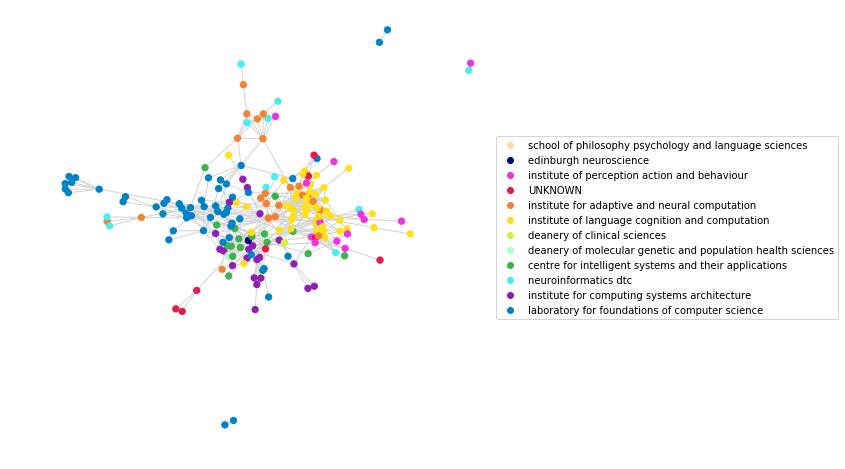

In [109]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.axis('off')
nx.draw_networkx(
    g_poinf_only,
    pos=pos,
    with_labels=False,
    ax=ax,
    node_size=40,
    edge_color='#D3D3D3',
    node_color=color_by_inst(g_poinf_only))

if SAVE_GRAPHS:
#     ax.set_title('Informatics Collaboration Network from 1997-2017')
    ax = add_inst_labels(ax) #You can include the label by uncommenting `ax = add_inst_label(ax)`
    plt.savefig("IMG/infnet20yr_spring.pdf", format='pdf', bbox_inches="tight")

#### `Shell Layout`

In [87]:
nlist = [[] for i in range(12)]

In [88]:
for node in g_poinf_only:
    c = int(lookup_poinf.institute_class.loc[[str(node)]])
    nlist[c].append(str(node))
# sort the list according to the size of the list, so that larger circles are outside.
nlist_dict = {len(a):[] for a in nlist}
for lst in nlist:
    nlist_dict[len(lst)].extend(lst)

In [105]:
length = list(nlist_dict.keys())
# length.sort(reverse=True)
_nlist = []
for l in length:
    _nlist.append(nlist_dict[l])

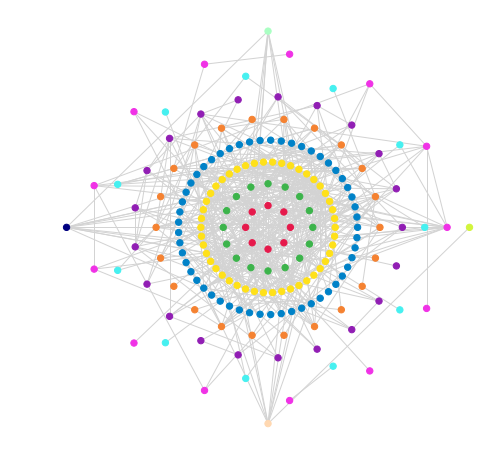

In [110]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.axis('off')
nx.draw_networkx(
    g_poinf_only,
    pos=nx.shell_layout(g_poinf_only, _nlist),
    with_labels=False,
    ax=ax,
    edge_color='#D3D3D3',
    node_size=40,
    node_color=color_by_inst(g_poinf_only))

if SAVE_GRAPHS:
#     ax.set_title('Informatics Collaboration Network from 1997-2017')
#     ax = add_inst_labels(ax) #You can include the label by uncommenting `ax = add_inst_label(ax)`
    plt.savefig("IMG/infnet20yr_shell.pdf", format='pdf', bbox_inches="tight")

#### `3D network graph`

In [33]:
import igraph as ig
from plotly.graph_objs import *
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as offline
offline.init_notebook_mode()

In [34]:
igraph_G = ig.Graph.TupleList(g_poinf_only.edges)
layt = igraph_G.layout('kk', dim=3)
vs = igraph_G.vs

In [35]:
TRACES = []

_data = {}
# VERTICES
for _id in g_poinf_only.nodes:
    _idx = vs.find(_id).index
    _k = lookup_poinf.loc[_id].institute_class  # institute_class of individual
    if _k in list(_data.keys()):
        _data[_k]['Xn'].append(layt[_idx][0])  # x-coordinates
        _data[_k]['Yn'].append(layt[_idx][1])  # y-coordinates
        _data[_k]['Zn'].append(layt[_idx][2])  # z-coordinates
        _data[_k]['ids'].append(_id)
    else:
        _data[_k] = {
            'Xn': [layt[_idx][0]],
            'Yn': [layt[_idx][1]],
            'Zn': [layt[_idx][2]],
            "ids": [_id]
        }

# Scatter nodes
for k in sorted(_data.keys()):
    v = _data[k]
    labels = lookup_poinf.loc[v['ids']].full_name.tolist()
    _trace = Scatter3d(
        x=v['Xn'],
        y=v['Yn'],
        z=v['Zn'],
        mode='markers',
        marker=Marker(
            symbol='dot',
            size=6,
            color=inst_by_color[k],
            line=Line(color='rgb(50,50,50)', width=0.5)),
        text=labels,
        hoverinfo='text',
        showlegend=True,
        name=[n for (n, _k) in list(institutes.items()) if _k == k][0])
    TRACES.append(_trace)

In [36]:
# Scatter edges
# EDGES
Xe, Ye, Ze = [], [], []
vs = igraph_G.vs
for (a, b) in g_poinf_only.edges:
    _a_idx = vs.find(a).index
    _b_idx = vs.find(b).index
    # x-coordinates of edge ends
    Xe += [layt[_a_idx][0], layt[_b_idx][0], None]
    Ye += [layt[_a_idx][1], layt[_b_idx][1], None]
    Ze += [layt[_a_idx][2], layt[_b_idx][2], None]

trace1 = Scatter3d(
    x=Xe,
    y=Ye,
    z=Ze,
    mode='lines',
    line=Line(color='rgb(125,125,125)', width=2),
    hoverinfo="none",
    showlegend=False)
TRACES.append(trace1)

In [37]:
axis = dict(
    showbackground=False,
    showline=False,
    zeroline=False,
    showgrid=False,
    showticklabels=False,
    title="")

In [38]:
layout = Layout(
    title="Informatics Collaboration Network from 1997-2017",
    width=1000,
    height=1000,
    showlegend=True,
    legend=dict(x=0, y=0, xanchor='auto', yanchor='auto'),
    scene=Scene(
        xaxis=XAxis(axis),
        yaxis=YAxis(axis),
        zaxis=ZAxis(axis),
    ),
    margin=Margin(t=50),
    #     hovermode="x",
    #     xaxis={"range":[1997,2017], 'title':'Year'},
    #     sliders={
    #         'args':[
    #             'trainsition', {
    #                 'duration': 400,
    #                 'easing':'cubic-in-out'
    #             }
    #         ],
    #         'initialValue':'1997',
    #         'plotlycommand':'animate',
    #         'values':years,
    #         'visible':True
    #     }
    #     annotations=Annotations([
    #         Annotation(
    #             showarrow=False,
    #             text='Colored by institutes',
    #             xref='paper',
    #             yref='paper',
    #             x=0,
    #             y=0.1,
    #             xanchor='left',
    #             yanchor='bottom',
    #             font=Font(size=14))
    #     ]),
)

In [39]:
data=Data(TRACES)
fig=Figure(data=data, layout=layout)
offline.iplot(fig)

### Collaboration within departments

In this section we visualise each of the seven institutes in School of Informatics
- class 1-centre for intelligent systems and their applications
- class 2-institute of language cognition and computation
- class 3-laboratory for foundations of computer science
- class 4-institute for adaptive and neural computation
- class 5-institute for computing systems architecture
- class 6-neuroinformatics dtc
- class 7-institute of perception action and behaviour

In [40]:
gb_dept = lookup_poinf.groupby('institute_class')

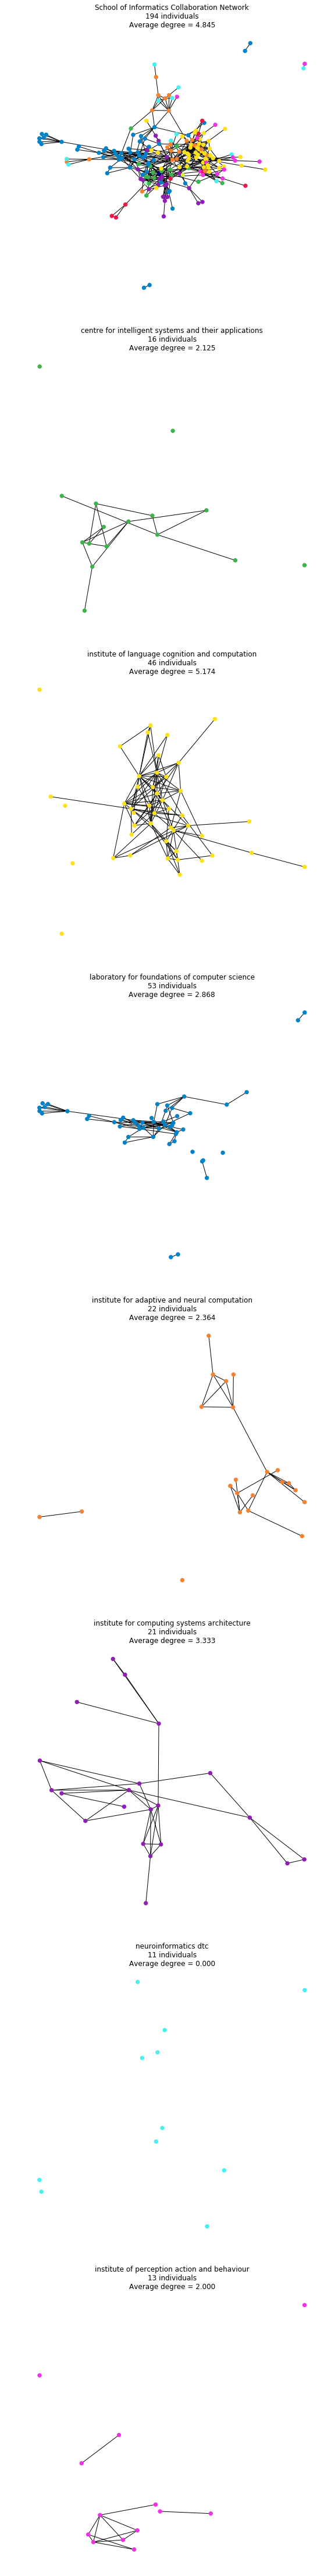

In [111]:
# visualise:
fig = plt.figure(figsize=(9, 80))
ax = fig.add_subplot(8, 1, 1)
ax.axis('off')
ax.set_title(
    'School of Informatics Collaboration Network\n{} individuals\nAverage degree = {:.3f}'.
    format(
        len(g_poinf_only),
        (sum(dict(g_poinf_only.degree).values()) / len(g_poinf_only))))
nx.draw_networkx(
    g_poinf_only,
    pos=pos,
    with_labels=False,
    ax=ax,
    node_size=40,
    node_color=color_by_inst(g_poinf_only))

ks = [1, 2, 3, 4, 5, 6, 7]
for k in ks:
    inst = [name for (name, _k) in list(institutes.items()) if _k == k][0]
    ax = fig.add_subplot(8, 1, k + 1)
    ax.axis('off')
    individuals = gb_dept.get_group(k).index
    g = g_poinf_only.subgraph(individuals)
    nx.draw_networkx(
        g,
        pos=pos,
        with_labels=False,
        ax=ax,
        node_size=40,
        nodelist=g.nodes,
        node_color=color_by_inst(g))
    title = "{}\n{} individuals\nAverage degree = {:.3f}".format(
        inst, len(g),
        sum(dict(g.degree).values()) / len(g))
    ax.set_title(title)
    
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet20yr_strat_department.pdf", format='pdf', bbox_inches="tight")

### Collaboration across departments
Now, we can calculate collaborative work between departments
1. Using the nodes between any two departments,
2. calculate number of collaboration between departments by removing collaborations between individuals in the department

In [42]:
from itertools import combinations
import numpy as np

In [43]:
import seaborn as sns

In [44]:
results = np.zeros([7,7])

In [45]:
for a,b in combinations(ks, 2):
    count = 0
    A = list(gb_dept.get_group(a).index)
    B = list(gb_dept.get_group(b).index)
    nodelist = A+B
    collab = g_poinf_only.subgraph(nodelist).edges()
    for (x,y) in collab:
        if (x in A and y in B) or (x in B and y in A):
            count += 1
    ratio = count/len(collab)
    results[b-1,a-1] = ratio # for lower triangle representation

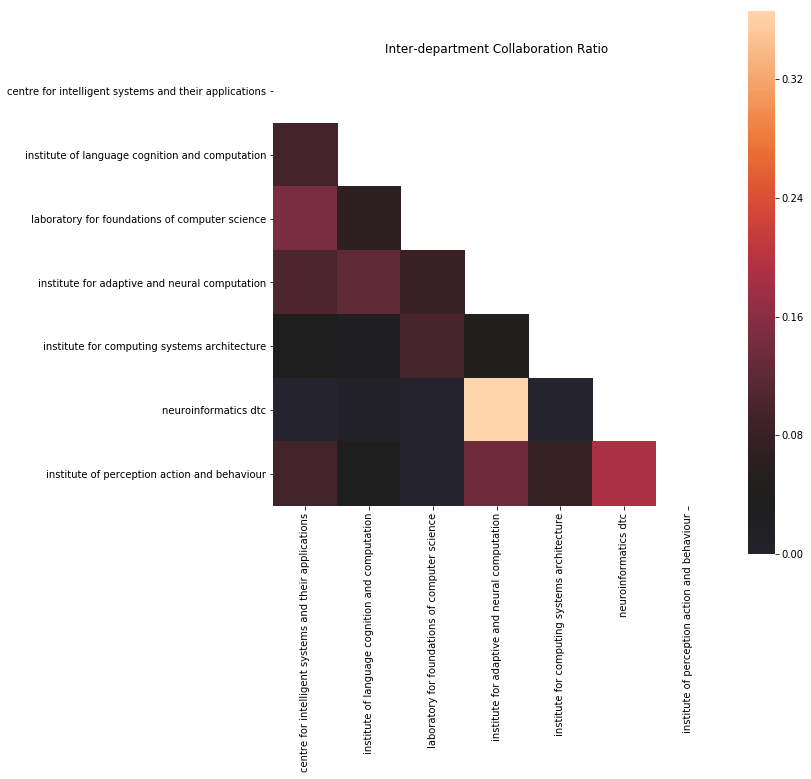

In [112]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
mask = np.zeros_like(results)
mask[np.triu_indices_from(mask)] = True
ticks = [[name for (name, _k) in list(institutes.items())
                  if _k == k][0] for k in range(1, 8)]
sns.heatmap(
    results,
    mask=mask,
    center=np.mean(results),
    square=True,
    yticklabels=ticks,
    xticklabels=ticks,ax=ax)
ax.set_title('Inter-department Collaboration Ratio')

if SAVE_GRAPHS:
    plt.savefig("IMG/infnet20yr_collab_heatmap.pdf", format='pdf', bbox_inches="tight")

### Development of `infnet` every 5 years

We can now observe the evolution of the informatics network on a time scale of 5 years

In [47]:
years = np.linspace(1997,2017,num=5,dtype=int)

In [48]:
years

array([1997, 2002, 2007, 2012, 2017])

In [49]:
# plt.style.use('seaborn-colorblind')
# print(plt.style.available)

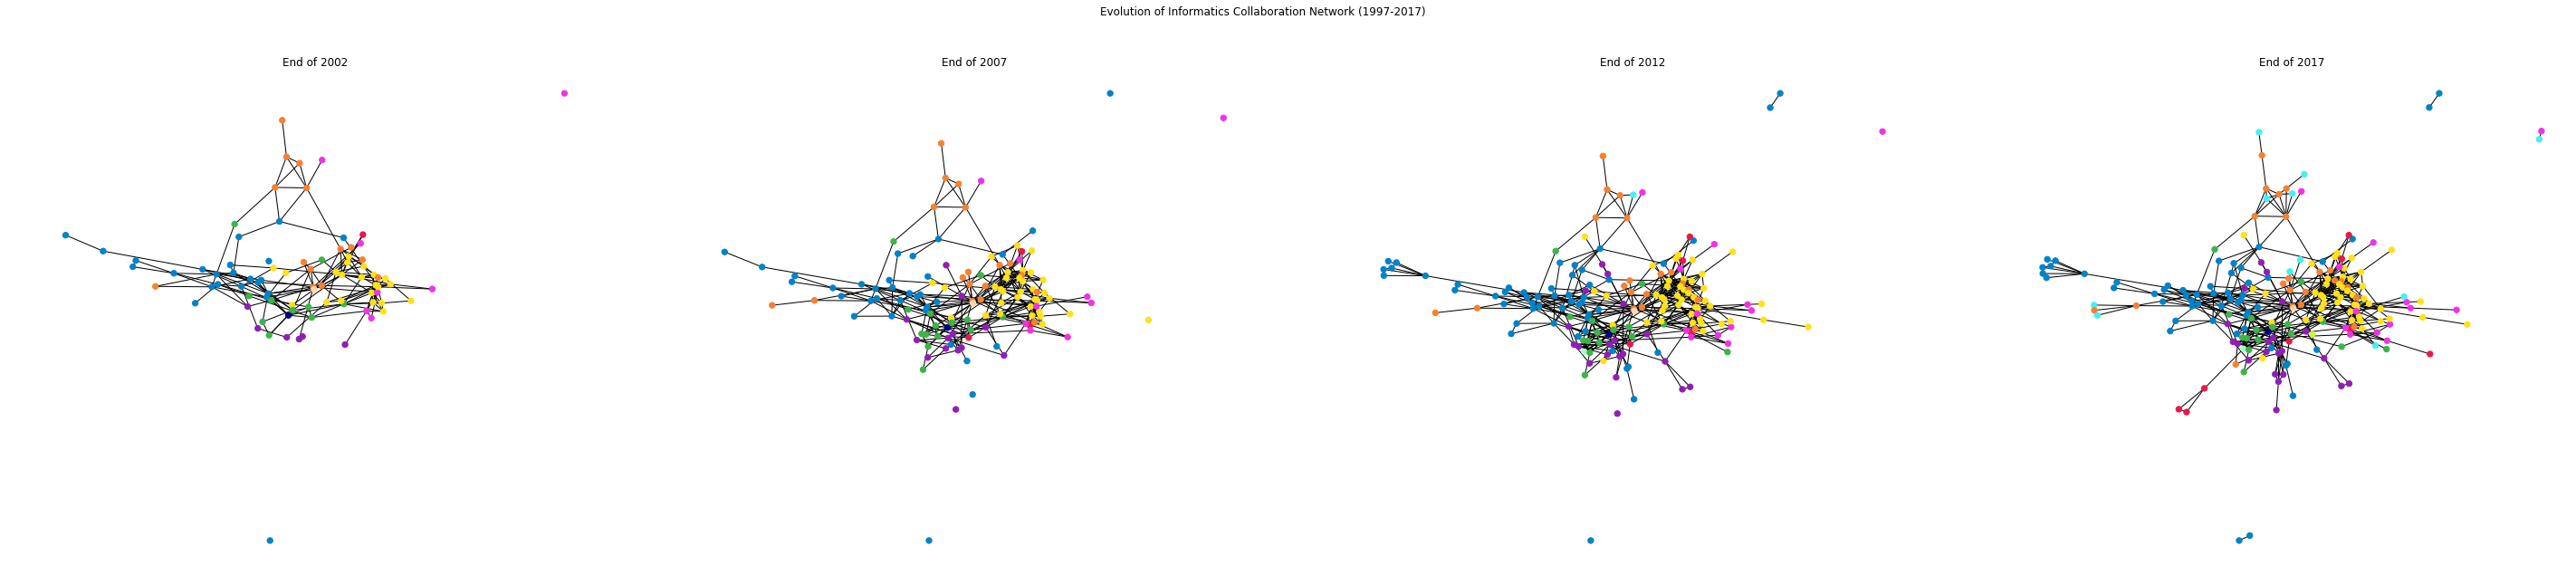

In [113]:
fig = plt.figure(figsize=(50, 10))
i =1
for yr in years[1:]:
    df = lookup_poinf.drop(
        lookup_poinf[lookup_poinf.first_pub_year > yr].index)
    individuals = list(df.index)
    g = g_poinf_only.subgraph(individuals)
    ax = fig.add_subplot(1, 4, i)
    ax.set_title('End of {}'.format(yr))
    ax.axis('off')
    i += 1
    
    nx.draw_networkx(
        g,
        pos=pos,
        with_labels=False,
        ax=ax,
        node_size=40,
        nodelist=g.nodes,
        node_color=color_by_inst(g))


if SAVE_GRAPHS:
    fig.suptitle('Evolution of Informatics Collaboration Network (1997-2017)')
    plt.savefig("IMG/infnet20yr_evolution.pdf", format='pdf', bbox_inches="tight")

## Statistics

In [51]:
from helper import *  # Helper functions!

### Degree distribution

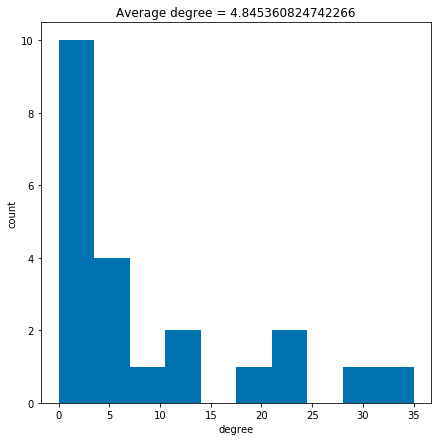

In [52]:
ax, degree_seq = degree_dist(g_poinf_only)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning:

invalid value encountered in true_divide



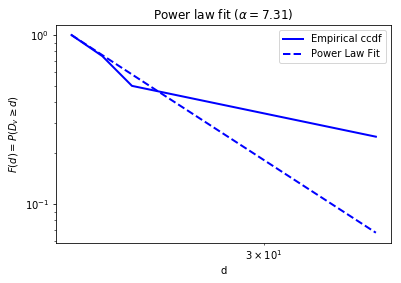

In [114]:
# we can observe the power-law fit to our degree distribution:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet20yr_degreeDist.pdf", format='pdf', bbox_inches="tight")

ideally, a log-log plot on the ccdf with power-law should yield a straight line

### Clustering coefficients

In [55]:
cc = clustering_coeff(g_poinf_only)
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.369063959421752


In [56]:
# The number of triangles for each nodes
transitivity_graph = nx.transitivity(g_poinf_only)
print('Transitivity:', transitivity_graph)

Transitivity: 0.3079150579150579


### Connected components

In [57]:
gccs, percentage = generateGCC(g_poinf_only)

component 1: 96.91%
component 2: 1.03%
component 3: 1.03%
component 4: 1.03%


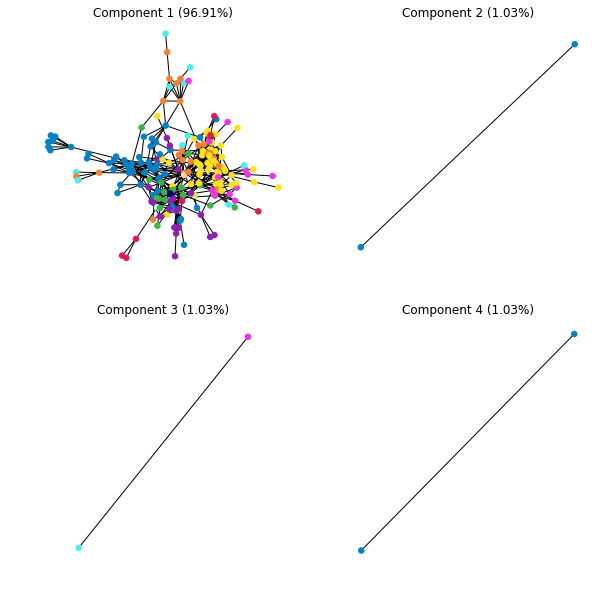

In [116]:
# display the connected components:
fig = plt.figure(figsize=(10, 10))
num_col = len(gccs) / 2
for i, g in enumerate(gccs, 1):
    percent = percentage[i - 1]
    ax = fig.add_subplot(num_col, 2, i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        node_size=30,
        pos=pos)
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet20yr_CC.pdf", format='pdf', bbox_inches="tight")

### Giant Connected Component
Now, we analyse the giant connected component from the network

In [60]:
main_gcc = gccs[0]  # First element is our GCC as we have sorted in reverse
pos_gcc = nx.spring_layout(main_gcc)

In [61]:
print('number of nodes in largest connected component:', len(main_gcc))

number of nodes in largest connected component: 188


In [62]:
print(nx.info(main_gcc))

Name: 
Type: Graph
Number of nodes: 188
Number of edges: 467
Average degree:   4.9681


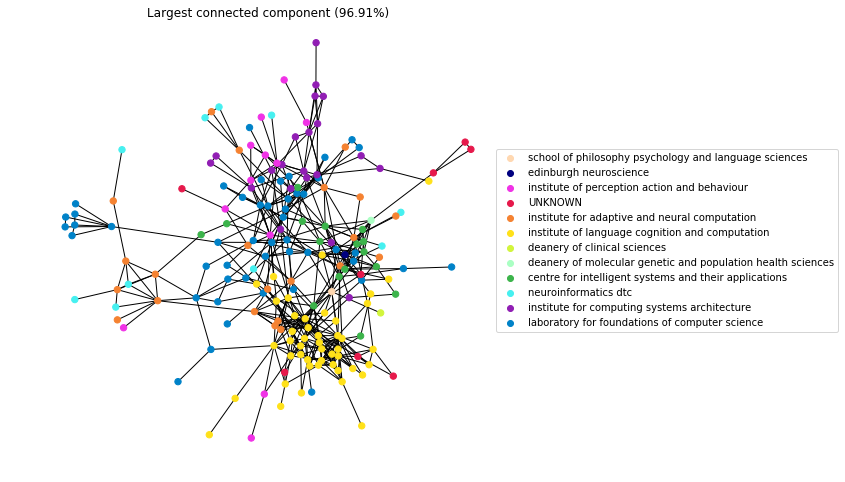

In [117]:
# Draw the Network
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=40,
    node_color=color_by_inst(main_gcc))
ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]))
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet20yr_LargestCC.pdf", format='pdf', bbox_inches="tight")

#### Degree Distribution

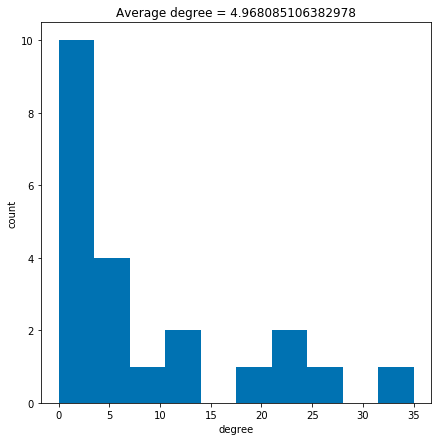

In [65]:
ax, degree_seq = degree_dist(main_gcc)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning:

invalid value encountered in true_divide



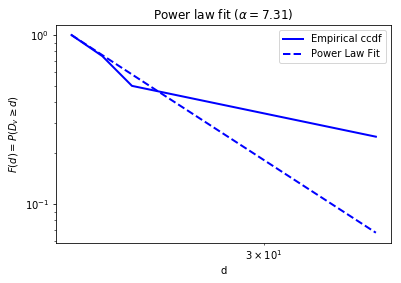

In [118]:
fig = power_law_fit(degree_seq)
if SAVE_GRAPHS:
    plt.savefig(
        "IMG/infnet20yr_LargestCC-degreeDist.pdf", format='pdf', bbox_inches="tight")

#### Clustering Coefficient

In [67]:
cc = clustering_coeff(main_gcc)

In [68]:
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.3808425964245739


#### Average Path & Diameter

In [69]:
nx.average_shortest_path_length(main_gcc)  # AVERAGE PATH

4.065365798156787

In [70]:
# Diameter:
print('Diameter of graph:', nx.diameter(main_gcc))

Diameter of graph: 10


#### Community detection

In [71]:
import community

In [ ]:
# Community detection using modularity
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]
# assign each node to the community they belong to

In [ ]:
# Plot the networks side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(
    'Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)'
)
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=40,
    node_color=color_by_inst(main_gcc))
ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=40,
    with_labels=False)
plt.savefig(
    "IMG/infnet_LargestCC_commCompare.pdf", format='pdf', bbox_inches="tight")

In [ ]:
num_comm = len(set(parts.values()))
print('Number of communities detected =', num_comm)

In [ ]:
# plot each community:
fig = plt.figure(figsize=(10, 30))
comms = set(parts.values())
for i, comm_id in enumerate(comms, 1):
    ax = fig.add_subplot(6, 2, i)
    # find those nodes belonging to this community:
    nodes_from_comm = [
        node_id for (node_id, c) in parts.items() if c == comm_id
    ]
    # Generate the subgrph belonging to these nodes:
    subG = nx.subgraph(main_gcc, nodes_from_comm)
    ax.axis('off')
    ax.set_title('Community {}'.format(comm_id))

    nx.draw_networkx(
        subG,
        pos=pos_gcc,
        ax=ax,
        node_color=color_by_inst(nodes_from_comm),
        node_size=20,
        with_labels=False)
ax = add_inst_labels(ax)
plt.savefig(
    "IMG/infnet_LargestCC_communities.pdf", format='pdf', bbox_inches="tight")

#### Influential individuals
Using betweness centrality as a mean to measure influence of node in the network

In [ ]:
bt = between_parallel(main_gcc)

In [ ]:
top = 11

In [ ]:
# we need to find the index of these max_nodes:
_nodes = list(main_gcc.nodes())

In [ ]:
max_nodes = sorted(bt.items(), key=lambda v: -v[1])[:top]
max_nodes

In [ ]:
# variables for plotting the network: values tell nx how big each node should be
bt_values = [10] * len(main_gcc.nodes())
bt_colors = ['xkcd:black'] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = (
        max_val * 150)**2.2  # SCALE IT ACCORDINGLY
    bt_colors[_nodes.index(max_key)] = inst_by_color[int(
        pd_poinf.institute_class.loc[[str(max_key)]])]

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.axis("off")
plt.suptitle('The top 11 influential individuals in the GCC')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    ax=ax,
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)
plt.savefig("IMG/infnet_influencer.pdf", format='pdf', bbox_inches="tight")

In [ ]:
top_ids = [a[0] for a in max_nodes]

In [ ]:
pd_poinf.loc[top_ids]

---

# 6yr Model :: 2012-2017

## Setup `lookup_pub`

In [ ]:
# Import the dataset:
lookup_pub = pd.read_pickle(os.path.join(DATA_DIR, 'lookup_pub.pkl'))

In [ ]:
# What are the years?
print(sorted(pd.unique(lookup_pub.year), reverse=True))

In [73]:
# There are some dates instead of just purely years.
# they all fall out of the 6 year period that we are interestted in (2017-2012)
# Grouping the publications by year:
gb = lookup_pub.groupby('year')
sixYears = [2017, 2016, 2015, 2014, 2013, 2012]
pd_years = {}
print("Year:\tPub count")
for yr, group in gb:
    if yr in sixYears:
        pd_years[yr] = group
        print("{}:\t{}".format(yr, len(group)))

Year:	Pub count
2012:	574
2013:	624
2014:	631
2015:	586
2016:	651
2017:	554


In [74]:
combined_yrs = pd.concat(pd_years.values())
print("Total publications: ", len(combined_yrs))

Total publications:  3620


In [75]:
all_edges_6yr = []
for listEdges in combined_yrs.edges:
    all_edges_6yr.extend(listEdges)
print('total number of edges: ', len(all_edges_6yr))

total number of edges:  29888


In [76]:
# Since the graph of interest is simple ud, we remove all repeated edges
unique_edges_6yr = set()
for (i1, i2) in all_edges_6yr:
    assert i1 != i2, "SELF LOOPS DETECTED!"

    # We are only interested in an simple undirected graph!
    # if the same edge exists, we can ignore
    if (i2, i1) in unique_edges_6yr:
        continue
    else:
        # adding another (i1,i2) into the set will only count as one
        unique_edges_6yr.add((i1, i2))

In [77]:
print('number of unique edge pairs: ', len(unique_edges_6yr))

number of unique edge pairs:  19890


In [79]:
# Filter all edges pairs if there is only one or none individuals from school of informatics
poinf6yr_edges_only = [(au1, au2) for (au1, au2) in unique_edges_6yr
                       if au1 in lookup_poinf.index and au2 in lookup_poinf.index]

In [80]:
print('size of collaboration network (number of edges): ',
      len(poinf6yr_edges_only))

size of collaboration network (number of edges):  360


Note the large decrease in edges with and without external individuals (from 19,890 to 360)

### Graphing Infnet (6yr model)

In [120]:
g_poinf_only_6yr = nx.from_edgelist(poinf6yr_edges_only)
pos_6yr = nx.spring_layout(g_poinf_only_6yr,random_state=rng)

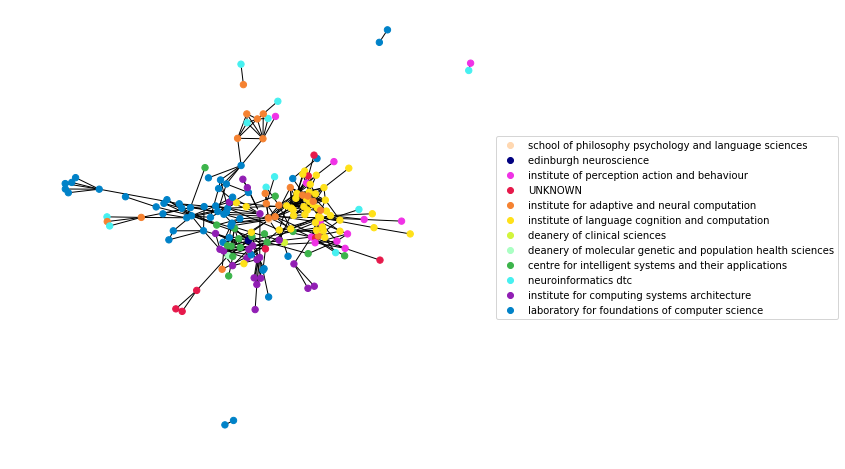

In [123]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.axis('off')
nx.draw_networkx(
    g_poinf_only_6yr,
    pos=pos,
    with_labels=False,
    ax=ax,
    node_size=40,
    node_color=color_by_inst(g_poinf_only_6yr))
if SAVE_GRAPHS:
    ax=add_inst_labels(ax)
    plt.savefig("IMG/infnet6yr_full_graph.pdf", format='pdf', bbox_inches="tight")

In [124]:
print(nx.info(g_poinf_only_6yr))

Name: 
Type: Graph
Number of nodes: 183
Number of edges: 360
Average degree:   3.9344


## Statistics

### Degree distribution

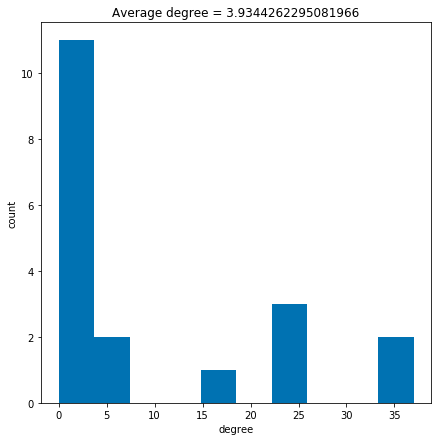

In [125]:
ax, degree_seq = degree_dist(g_poinf_only_6yr)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning:

invalid value encountered in true_divide



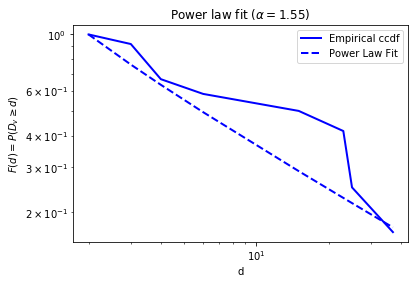

In [126]:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet6yr_degreeDist.pdf", format='pdf', bbox_inches="tight")

### Clustering coefficient

In [127]:
cc = clustering_coeff(g_poinf_only_6yr)
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.42507862061864


In [128]:
# The number of triangles for each nodes
transitivity_graph = nx.transitivity(g_poinf_only_6yr)
print('Transitivity:', transitivity_graph)

Transitivity: 0.3979591836734694


### Connected Components

In [129]:
gccs, percentage = generateGCC(g_poinf_only_6yr)

component 1: 94.54%
component 2: 1.09%
component 3: 1.09%
component 4: 1.09%
component 5: 1.09%
component 6: 1.09%


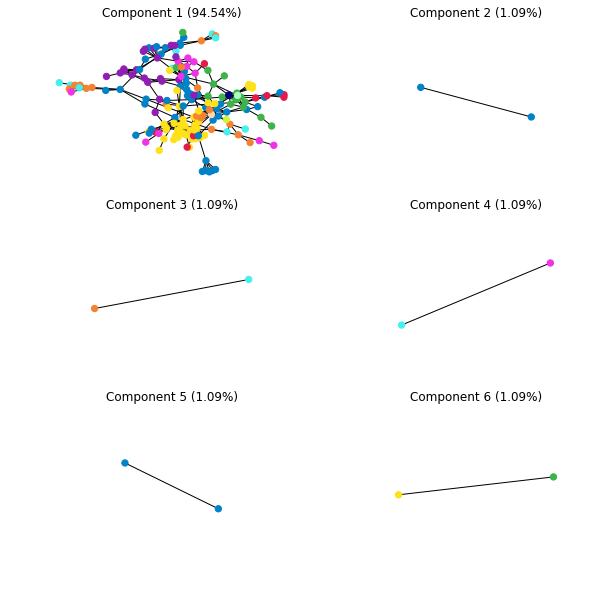

In [130]:
# display the connected components:
fig = plt.figure(figsize=(10, 10))
num_col = len(gccs) / 2
for i, g in enumerate(gccs, 1):
    percent = percentage[i - 1]
    ax = fig.add_subplot(num_col, 2, i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        node_size=40,
        pos=pos_6yr)
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet6yr_CC.pdf", format='pdf', bbox_inches="tight")

## Giant Connected Component

In [132]:
main_gcc = gccs[0]
pos_gcc = nx.spring_layout(main_gcc, random_state=rng)

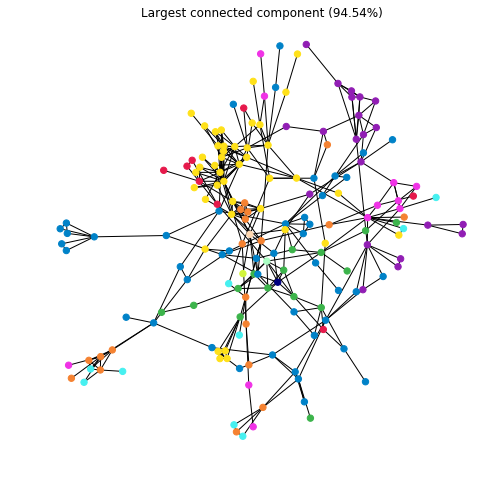

In [136]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=40,
    node_color=color_by_inst(main_gcc)
)
if SAVE_GRAPHS:
    ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]));
    plt.savefig("IMG/infnet6yr_LargestCC.pdf", format='pdf', bbox_inches="tight")
    

In [137]:
print('number of nodes in largest connected component:', len(main_gcc))
print(nx.info(main_gcc))

number of nodes in largest connected component: 173
Name: 
Type: Graph
Number of nodes: 173
Number of edges: 355
Average degree:   4.1040


### Degree distribution

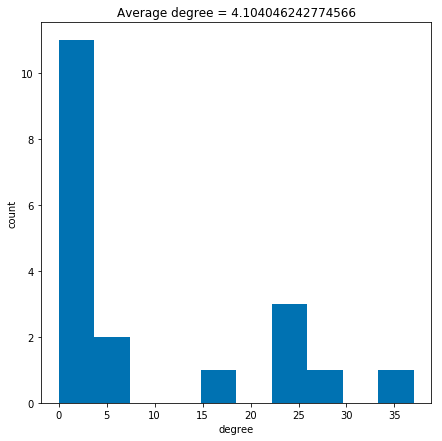

In [138]:
ax, degree_seq = degree_dist(main_gcc)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning:

invalid value encountered in true_divide



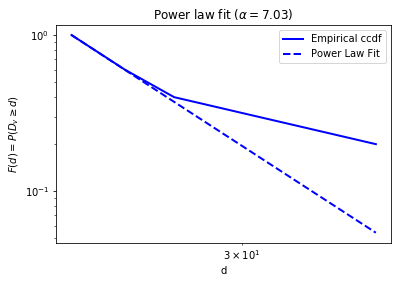

In [139]:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet6yr_LargestCC_degreeDist.pdf", format='pdf', 
            bbox_inches="tight")

### Clustering Coefficient

In [140]:
cc = clustering_coeff(main_gcc)
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.44964963915150924


### Average Path & Diameter

In [141]:
nx.average_shortest_path_length(main_gcc) # AVERAGE PATH

4.986490119639736

In [142]:
# Diameter:
print('Diameter of graph:', nx.diameter(main_gcc))

Diameter of graph: 11


### Community detection

In [ ]:
# Community detection using modularity
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]  
# assign each node to the community they belong to

In [ ]:
# Plot the graphs side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)')
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=40,
    node_color=color_by_inst(main_gcc)
)


ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=40,
    with_labels=False)
plt.savefig("IMG/infnet6yr_LargestCC_commCompare.pdf", format='pdf', 
            bbox_inches="tight")

In [ ]:
num_comm = len(set(parts.values()))
print('Number of communities detected =', num_comm)

In [ ]:
# plot each community:
fig = plt.figure(figsize=(10,30))
comms = set(parts.values())
for i, comm_id in enumerate(comms, 1):
    ax = fig.add_subplot(6,2,i)
    # find those nodes belonging to this community:
    nodes_from_comm = [node_id for (node_id, c) in parts.items() if c == comm_id]
    # Generate the subgrph belonging to these nodes:
    subG = nx.subgraph(main_gcc, nodes_from_comm)
    ax.axis('off')
    ax.set_title('Community {}'.format(comm_id))
    
    nx.draw_networkx(
        subG,
        pos=pos_gcc,
        ax=ax,
        node_color=color_by_inst(nodes_from_comm),
        node_size=40,
        with_labels=False)
ax = add_inst_labels(ax)
plt.savefig("IMG/infnet6yr_LargestCC_communities.pdf", format='pdf', 
            bbox_inches="tight")

### Influential individuals

In [ ]:
bt = between_parallel(main_gcc)

In [ ]:
top = 11

In [ ]:
# we need to find the index of these max_nodes:
_nodes = list(main_gcc.nodes())

In [ ]:
max_nodes = sorted(bt.items(), key=lambda v: -v[1])[:top]
max_nodes

In [ ]:
bt_values = [10] * len(main_gcc.nodes())
bt_colors = ['xkcd:black'] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = (max_val * 150)**2.2
    bt_colors[_nodes.index(max_key)] = inst_by_color[int(
        pd_poinf.institute_class.loc[[str(max_key)]])]

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.axis("off")
plt.suptitle('The top 11 influential individuals in the GCC')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    ax=ax,
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)
plt.savefig("IMG/infnet6yr_influencer.pdf", format='pdf', 
            bbox_inches="tight")

In [ ]:
top_ids = [a[0] for a in max_nodes]
pd_poinf.loc[top_ids]

# Weighted 6yr Model
IN this section, we explore a version of the weight simple undirected grap of the 6yr model.
The calculation of the weight of an edge is the sum of contributions by each author pair for all their publications (publication which involve both of them (and others).

Contributions are calculated as $$\text{contribution}(u,v) = \frac{1}{\text{size of complete graph}} = \frac{1}{{N}\choose{2}} = \frac{1}{\frac{N(N-1)}{2}} = \frac{2}{N(N-1)}$$ where $N$ is the number of authors for a publication.

Weight of edge between authors $u$ and $v$ 
$$weight(u,v) = \sum_{i=1}^{N}\text{contribution}_{i}(u,v)$$

## Setup

In [143]:
def get_edge_weight(authors):
    # function to calculate the edge weight for each publication
    if len(authors) > 1:
        n = len(authors)
        k = 2. / (n * (n - 1))
    else:
        k = 0.
    return k

In [144]:
combined_yrs['weight'] = combined_yrs.apply(
    lambda row: get_edge_weight(row.collab_id), axis=1)

In [145]:
combined_yrs.iloc[1]

year                                            2012
authors                           j michael herrmann
shortnames                           herrmann, j. m.
collab_id     [cf1b7c31-3a87-4812-bf0a-05cf49b0120e]
edges                                             []
weight                                             0
Name: 1e8a5570-68a8-4863-b795-368018f426e3, dtype: object

In [147]:
# Add the edges to the network with weight attribute
g_poinf_weighted = nx.Graph()
for row in combined_yrs.itertuples():
    edgelist = row.edges
    weight = row.weight
    for (a, b) in edgelist:
        if a in lookup_poinf.index and b in lookup_poinf.index:
            g_poinf_weighted.add_edge(a, b, weight=weight)

In [148]:
edgewidth = [
    d['weight'] * 2. for (u, v, d) in g_poinf_weighted.edges(data=True)
]  # weights for each edges
print(nx.info(g_poinf_weighted))

Name: 
Type: Graph
Number of nodes: 183
Number of edges: 360
Average degree:   3.9344


In [149]:
assert not set(g_poinf_only_6yr.nodes).difference(
    set(g_poinf_weighted.nodes
        )), "Same number of nodes for both 6yr model should be observer"

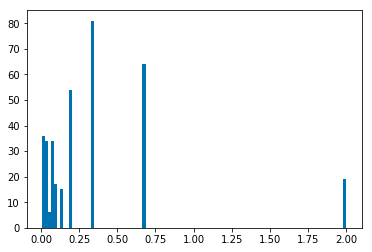

In [150]:
# Take a look at the distribution of edgewidth
plt.hist(edgewidth, bins=100)
plt.savefig('IMG/infnet6yrw_tofWeights.pdf', format='pdf', bbbox_inches="tight")

### Graphing Weighted Network

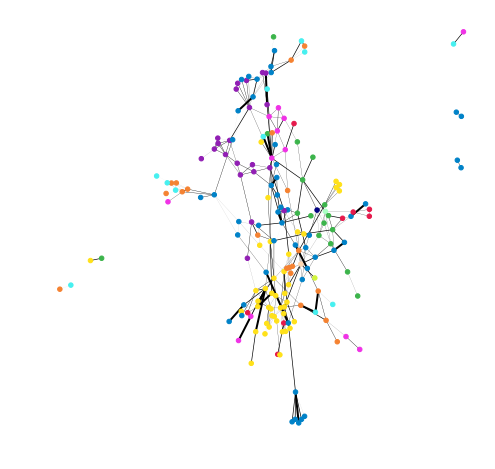

In [159]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax=add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx_nodes(
    g_poinf_weighted,
    pos=pos_6yr,
    with_labels=False,
    ax=ax,
    node_size=20,
    node_color=color_by_inst(g_poinf_weighted))
nx.draw_networkx_edges(
    g_poinf_weighted,
    pos_6yr,
    width=edgewidth,
)
if SAVE_GRAPHS:
    plt.savefig(
        "IMG/infnet6yrw_full_graph.pdf", format='pdf', bbox_inches="tight")

## Statistics
Degree distribution is the same as 3.2.1

### Clustering

In [153]:
print('Average clustering coeff: ',
      nx.average_clustering(g_poinf_weighted, weight='weight'))

Average clustering coeff:  0.056371131656413796


This is lower than the unweighted graph ( 0.421964851597)!

### Connected Components

In [154]:
gccs, percentage = generateGCC(g_poinf_weighted)

component 1: 94.54%
component 2: 1.09%
component 3: 1.09%
component 4: 1.09%
component 5: 1.09%
component 6: 1.09%


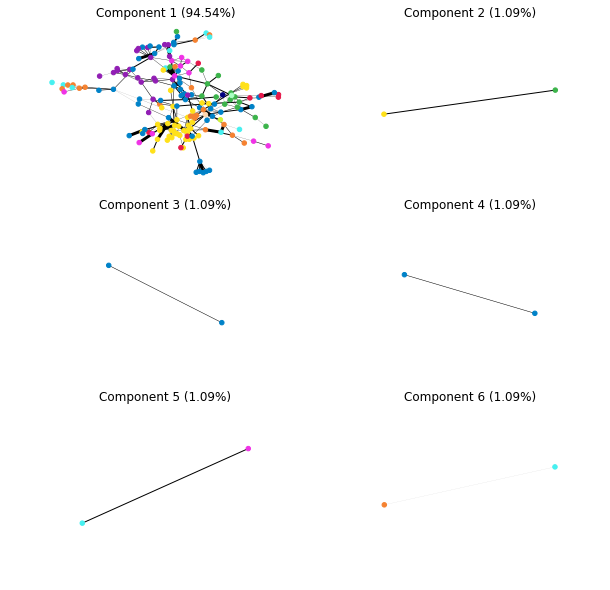

In [160]:
# display the connected components:
fig = plt.figure(figsize=(10, 10))
num_col = len(gccs) / 2
for i, g in enumerate(gccs, 1):
    percent = percentage[i - 1]
    ax = fig.add_subplot(num_col, 2, i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx_nodes(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        node_size=20,
        pos=pos_6yr)
    g_edgewidth = [d['weight'] for (u, v, d) in g.edges(data=True)]
    nx.draw_networkx_edges(g, pos_6yr, width=np.multiply(g_edgewidth, 3))

plt.savefig("IMG/infnetweighted_CC.pdf", format='pdf', bbox_inches="tight")

In [156]:
main_gcc = gccs[0]

In [157]:
print('number of nodes in largest connected component:', len(main_gcc))
print(nx.info(main_gcc))

number of nodes in largest connected component: 173
Name: 
Type: Graph
Number of nodes: 173
Number of edges: 355
Average degree:   4.1040


## Giant Connected Component

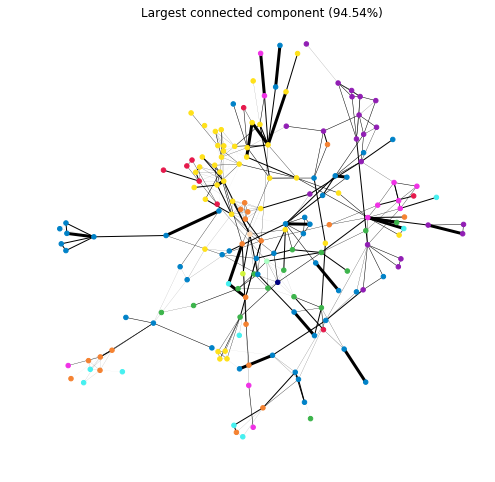

In [158]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=20,
    node_color=color_by_inst(main_gcc))
main_gcc_edgewidth = [d['weight'] for (u, v, d) in main_gcc.edges(data=True)]
nx.draw_networkx_edges(
    main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth, 3))
ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]))

if SAVE_GRAPHS:
    plt.savefig(
    "IMG/infnet6yrw_LargestCC.pdf", format='pdf', bbox_inches="tight")

(array([35., 34.,  6., 34., 17.,  0., 15.,  0.,  0., 54.,  0.,  0.,  0.,
         0.,  0.,  0., 79.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 62.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 19.]),
 array([0.00362319, 0.01358696, 0.02355072, 0.03351449, 0.04347826,
        0.05344203, 0.0634058 , 0.07336957, 0.08333333, 0.0932971 ,
        0.10326087, 0.11322464, 0.12318841, 0.13315217, 0.14311594,
        0.15307971, 0.16304348, 0.17300725, 0.18297101, 0.19293478,
        0.20289855, 0.21286232, 0.22282609, 0.23278986, 0.24275362,
        0.25271739, 0.26268116, 0.27264493, 0.2826087 , 0.29257246,
        0.30253623, 0.3125

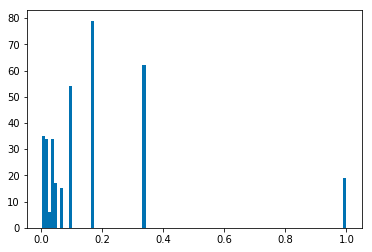

In [161]:
plt.hist(
    main_gcc_edgewidth, bins=100)

In [162]:
print('Average clustering coeff: ',
      nx.average_clustering(main_gcc, weight='weight'))

Average clustering coeff:  0.05962957857296951


In [163]:
print('Average shortest path length: ',
      nx.average_shortest_path_length(main_gcc, weight='weight'))

Average shortest path length:  0.6656710947376739


### Community Detection

In [ ]:
# Community detection using modularity
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]
# assign each node to the community they belong to

In [ ]:
print('Number of communities detected: ', len(set(values)))

In [ ]:
# Plot the graphs side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(
    'Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)'
)
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=20,
    node_color=color_by_inst(main_gcc))
nx.draw_networkx_edges(
    main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth, 3))

ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=20,
    with_labels=False)
nx.draw_networkx_edges(
    main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth, 3))
plt.savefig(
    "IMG/infnetweight_LargestCC_commCompare.pdf",
    format='pdf',
    bbox_inches="tight")

### Influential Individuals
We use the top scores for the eigenvector centrality to determine who are the most influential individuals

In [ ]:
evect_centrality = nx.eigenvector_centrality_numpy(main_gcc, weight='weight')

In [ ]:
max_nodes = sorted(evect_centrality.items(), key=lambda v: -v[1])[:top]
max_nodes

In [ ]:
bt_values = [10] * len(main_gcc.nodes())
bt_colors = ['xkcd:black'] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = (max_val * 100)**2
    bt_colors[_nodes.index(max_key)] = inst_by_color[int(
        pd_poinf.institute_class.loc[[str(max_key)]])]

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.axis("off")
plt.suptitle('The top 11 influential individuals in the GCC')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    ax=ax,
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)
nx.draw_networkx_edges(
    main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth, 3))
plt.savefig(
    "IMG/infnetweight_influencer.pdf", format='pdf', bbox_inches="tight")

In [ ]:
top_ids = [a[0] for a in max_nodes]
pd_poinf.loc[top_ids]